In this notebook we select the cognitive factors of our interest in the behavioural data of the human connectome. 

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import h5py

from os.path import join as opj
import seaborn as sns
import matplotlib.pylab as plt

from scipy.stats import spearmanr

In [2]:
data_dir = "/media/javier/data/local_fingerprint_varoquox/"
plot_dir = "../plots"

In [2]:
demo_S1200 = pd.read_excel(opj("../data", 'unrestricted_jraserod_8_16_2019_12_4_12.xlsx'))
info_demo =  pd.read_excel(opj("../data", 'HCP_S1200_DataDictionary_April_20_2018.xlsx'))
age = pd.read_excel(opj("../data", "age.xlsx"))
subjects = np.loadtxt(opj("../data", "subjects_finally_used.txt"), dtype = int)

In [3]:
cognition_cols = info_demo[info_demo.category == 'Cognition'].columnHeader

In [4]:
for name, line in zip(cognition_cols, info_demo[info_demo.category == 'Cognition'].description):
    print(name)
    print(line)
    print("" )

PicSeq_Unadj
The Picture Sequence Memory Test is an assessment of episodic memory for ages 3-85 years which involves the acquisition, storage and effortful recall of new information. It is considered a strong 'fluid ability' measure, with performance reaching a peak in early adulthood and declining across the life span. It involves recalling increasingly lengthy series of illustrated objects and activities that are presented in a particular order on the computer screen. Unadjusted Scale Score: Participant score is normed to those in the entire NIH Toolbox Normative Sample (18 and older), regardless of age or any other variable, where a score of 100 indicates performance that was at the national average and a score of 115 or 85, indicates performance 1 SD above or below the national average.

PicSeq_AgeAdj
The Picture Sequence Memory Test is an assessment of episodic memory for ages 3-85 years which involves the acquisition, storage and effortful recall of new information. It is conside

In [5]:
# Select the subset of subjects used
demo_sub = pd.merge(pd.DataFrame({'Subject':subjects}), demo_S1200, on='Subject')

In [6]:
demo_sub_w_age = pd.merge(demo_sub, age, on = 'Subject')

In [7]:
demo_sub_w_age.loc[:,['Age', 'Age_in_Yrs']].head()

,Age,Age_in_Yrs
0,26-30,27
1,26-30,27
2,31-35,33
3,26-30,27
4,31-35,35


If we compute the bins using the same cuts as in the age by bins, it should give the same result

In [8]:
pd.cut(demo_sub_w_age['Age_in_Yrs'], bins = [21, 25, 30, 35, 1000], 
       right=True, labels=["22-25", "26-30", "31-35", "36+"]).value_counts()

26-30    461
31-35    358
22-25    221
36+       10
Name: Age_in_Yrs, dtype: int64

In [9]:
demo_sub.Age.value_counts()

26-30    461
31-35    358
22-25    221
36+       10
Name: Age, dtype: int64

In [10]:
nan_scores = demo_sub_w_age.loc[:, cognition_cols].isna().any(axis=1)
print("There are %d subjects with at least one NaN score... \n" % nan_scores.sum())
print("These subjects are: ", list(demo_sub_w_age[nan_scores].Subject), '\n')
print("As a consequence, the final dataset of cognitive scores " 
      "will have %d total subjects" % demo_sub_w_age.loc[~nan_scores, cognition_cols].shape[0])

There are 21 subjects with at least one NaN score... 

These subjects are:  [102109, 111009, 111514, 137431, 140319, 146634, 156233, 178647, 191033, 214726, 236130, 284646, 390645, 393247, 429040, 510225, 594156, 635245, 688569, 706040, 872764] 

As a consequence, the final dataset of cognitive scores will have 1029 total subjects


In [11]:
demo_sub_w_age.loc[~nan_scores,:].Gender.value_counts()

F    550
M    479
Name: Gender, dtype: int64

In [12]:
demo_sub_w_age.loc[~nan_scores, 'Age_in_Yrs'].describe()

count    1029.000000
mean       28.734694
std         3.678544
min        22.000000
25%        26.000000
50%        29.000000
75%        32.000000
max        37.000000
Name: Age_in_Yrs, dtype: float64

In [13]:
Y_cognition = demo_sub_w_age.loc[~nan_scores, cognition_cols]
age_cognition = demo_sub_w_age.loc[~nan_scores, 'Age_in_Yrs'].values
age_ranges = demo_sub_w_age.loc[~nan_scores, 'Age'].values
subjects = demo_sub_w_age.loc[~nan_scores, 'Subject'].values

We just take one score for each of the predefine a priori cognitive domains. As a consequence, we will have in this scenario the following scores:

- CogTotalComp_Unadj (General cognition)
- CogFluidComp_Unadj (Fluid Intelligence)
- CogCrystalComp_Unadj (Crystallized Intelligence)
- SCPT_SEN (Sustained Attention)
- DDisc_AUC_200 (Impulsivity)
- IWRD_TOT (Working Memory)
- VSPLOT_TC (Spatial Orientation)

In [14]:
domain_scores = ['CogTotalComp_Unadj',
                 'CogFluidComp_Unadj', 
                 'CogCrystalComp_Unadj', 
                 'SCPT_SEN', 
                 'DDisc_AUC_200', 
                 'IWRD_TOT', 
                 'VSPLOT_TC']

In [15]:
Y_domain_cog = Y_cognition.loc[:, domain_scores]

In [16]:
from scipy.stats import kurtosis, skew
means = Y_domain_cog.mean()
medians = Y_domain_cog.median()
skews = skew(Y_domain_cog.values)
kurtosis = kurtosis(Y_domain_cog.values)
low_p, high_p = np.percentile(Y_domain_cog.values, q=[25, 75], axis=0)
iqr = high_p - low_p

In [17]:
mild_outliers = []
extreme_outliers = []

for ii in range(Y_domain_cog.shape[1]):
    
    data = Y_domain_cog.iloc[:, ii].values
    low_cond = low_p[ii] - iqr[ii]*1.5
    high_cond = high_p[ii] + iqr[ii]*1.5

    mild_outliers.append(sum((data < low_cond) | (data > high_cond))/len(data))
    
    low_cond = low_p[ii] - iqr[ii]*3.0
    high_cond = high_p[ii] + iqr[ii]*3.0

        
    extreme_outliers.append(sum((data < low_cond) | (data > high_cond))/len(data))

In [18]:
#Bootstrap to compute the confidence intervals
from sklearn.utils import resample

n_boots = 1000
alpha = 0.05
RANDOM_STATE = 0 

np.random.seed(RANDOM_STATE)


mean_boots = []
for ii in range(n_boots):
    Y_boot = resample(Y_domain_cog)
    
    mean_boots.append(np.mean(Y_boot, axis=0))
    
mean_boots = np.array(mean_boots)

low_ci, high_ci = np.quantile(mean_boots, axis=0, q=[alpha/2, 1-alpha/2])

In [19]:
# Table 1 of the paper
pd.DataFrame({'mean': np.round(means, 2), 
              'median': np.round(medians, 2), 
              'skewness': np.round(skews, 2), 
              'kurtosis': np.round(kurtosis, 2),
              '% Mild outliers': np.round(mild_outliers, 2),
              '% Extreme outliers': np.round(extreme_outliers,2),
              'low CI': np.round(low_ci, 2),
              'high CI': np.round(high_ci, 2)})

,mean,median,skewness,kurtosis,% Mild outliers,% Extreme outliers,low CI,high CI
CogTotalComp_Unadj,122.28,120.77,0.21,-0.49,0.00,0.00,121.37,123.17
CogFluidComp_Unadj,115.43,114.15,0.26,-0.46,0.00,0.00,114.72,116.13
CogCrystalComp_Unadj,117.90,117.81,0.11,0.09,0.01,0.00,117.29,118.50
SCPT_SEN,0.96,0.97,-3.29,19.76,0.04,0.01,0.95,0.96
DDisc_AUC_200,0.26,0.20,1.33,1.57,0.04,0.00,0.25,0.27
IWRD_TOT,35.64,36.00,-0.82,0.57,0.01,0.00,35.45,35.81
VSPLOT_TC,14.93,15.00,-0.27,-0.14,0.00,0.00,14.67,15.23


In [20]:
# In latex form
print(pd.DataFrame({'mean': np.round(means, 2), 
              'median': np.round(medians, 2), 
              'skewness': np.round(skews, 2), 
              'kurtosis': np.round(kurtosis, 2),
              '% Mild outliers': np.round(mild_outliers, 2),
              '% Extreme outliers': np.round(extreme_outliers,2),
              'low CI': np.round(low_ci, 2),
              'high CI': np.round(high_ci, 2)}).T.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  CogTotalComp\_Unadj &  CogFluidComp\_Unadj &  CogCrystalComp\_Unadj &  SCPT\_SEN &  DDisc\_AUC\_200 &  IWRD\_TOT &  VSPLOT\_TC \\
\midrule
mean               &              122.28 &              115.43 &                117.90 &      0.96 &           0.26 &     35.64 &      14.93 \\
median             &              120.77 &              114.15 &                117.81 &      0.97 &           0.20 &     36.00 &      15.00 \\
skewness           &                0.21 &                0.26 &                  0.11 &     -3.29 &           1.33 &     -0.82 &      -0.27 \\
kurtosis           &               -0.49 &               -0.46 &                  0.09 &     19.76 &           1.57 &      0.57 &      -0.14 \\
\% Mild outliers    &                0.00 &                0.00 &                  0.01 &      0.04 &           0.04 &      0.01 &       0.00 \\
\% Extreme outliers &                0.00 &                0.00 &                  0.00 &      0.01

<Figure size 720x720 with 0 Axes>

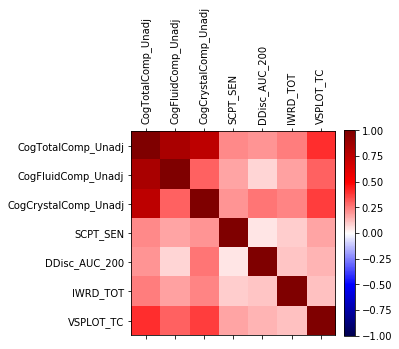

In [21]:
# Pearson Correlation between each score

plt.figure(figsize=(10, 10))
plt.matshow(Y_domain_cog.corr('spearman'), cmap='seismic', vmax=1, vmin=-1)

plt.yticks(np.arange(len(domain_scores)), domain_scores)
plt.xticks(np.arange(len(domain_scores)), domain_scores, rotation = 90)
plt.colorbar(fraction=0.046, pad=0.04)
pass

In [22]:
f = h5py.File(opj("../data", "data_response_variables.hdf5"), "w")

f.create_dataset("Y_cognition", data = Y_domain_cog.values)
f.create_dataset("age_cognition", data = age_cognition)
f.create_dataset("age_ranges", data = np.array(age_ranges, dtype='S'))
f.create_dataset("scores", data = np.array(domain_scores, dtype='S'))
f.create_dataset("subjects", data = subjects)
f.close()